### Task 1 : Voter Model
Kiamehr Javid, 2084294 \
Jelin Raphael Akkara, 2072064

### Loading Libraries

In [8]:
library(tibble)
library(dplyr)
library(tidyr)
library(readr)
library(purrr)
library(forcats)
library(igraph)
library(microbenchmark)
library(ggplot2)
library(parallel)
library(rlist)     
library(stringr)     

library(latex2exp)      #For Latex Labelling
library(RColorBrewer)   #For Color Palettes
library(gridExtra)      #For plotting in grid


### Functions for Network Topologies

In [9]:
#For SSF
deact_prob <- function(d,q,a) (q - 1) / (a + d)

#Initiating Network Topologies
initiate_SSF <- function(n=100,m=4,q=3,a=0.5){
  act <- as.list(1:m)
  g <- make_empty_graph(n , directed = F)
  g <- add_edges(g,combn(1:m,2))

  for(i in (m+1):n){
    el <- unlist(act)
    l <- length(el)
    el <- rep(el,each = 2)
    el[2*(1:l)-1] <- i
    g <- add_edges(g, el)
    degs <- degree(g,V(g))
    tbd <- unlist(sample(act,1,prob = deact_prob(degs[unlist(act)],q,a)))
    act[unlist(act) == tbd] <- i
  }
  g$degree <- degree(g, V(g))
  g$opinion <- sample(c(T, F), n, replace = TRUE)
  return(g)

}

initiate_SF <- function(n=100,m=4,de=1,ae=-1){
  g <- sample_pa_age(n, de , ae , m = m , directed = F)
  g <- simplify(g)
  g$degree <- degree(g, V(g))
  g$opinion <- sample(c(T, F), n, replace = TRUE)
  return(g)
}

initiate_LAT <- function(d=1,l=10){
  g <- make_lattice(dim=d,length=l)
  g <- simplify(g)
  g$degree <- degree(g, V(g))
  g$opinion <- sample(c(T, F), l**d, replace = TRUE)
  return(g)
}

initiate_SW <- function(d=2,l=10,nei=5,rew=0){
  g <- sample_smallworld(d,l,nei,rew)
  g <- simplify(g)
  g$degree <- degree(g, V(g))
  g$opinion <- sample(c(T, F), l**d, replace = TRUE)
  return(g)
}

initiate_ER <- function(n=100,m=3){
  g <- sample_gnm(n = n , m = n*m)
  g <- simplify(g)
  g$degree <- degree(g, V(g))
  g$opinion <- sample(c(T, F), n, replace = TRUE)
  return(g)
}

#Swapping Edges: Rewiring for Small World Networks
edge_swap <- function(g, p, loops = F){
  return(rewire(g, with = keeping_degseq(loops = loops, niter = ceiling(p*ecount(g)))))
}

CC <- function(g) transitivity(g,'global')


In [ ]:
#Implement Voter Model
do_voter <- function(dis, mode, g){

  n <- length(V(g))
  g <- edge_swap(g,dis)
  cnt <- 0
  Rho <- get_rho(g)
  adm <- as_adjacency_matrix(g,sparse = F)
  ifelse(mode == 'edge' , update <- edge_update, update <- function(g) node_update(g,adm))
  while(T){
    cnt <- cnt + 1
    g <- update(g)
    rho <- get_rho(g)
    Rho <- c(Rho,rho)
    if((rho == 0) | (cnt > 3*n) ) break
  }
  return(Rho)
}

### Functions for Updating Networks

In [7]:
node_update <- function(g, adj_matrix){

  #Gets the network size: Number of nodes/vertices
  n <- length(V(g))

  #Randomly sample n nodes (This is taken as one time unit)
  nodes <- sample(1:n, n, replace = TRUE)

  # For each sampled node -> Find the neighbouring nodes' indices -> Sample from list of neighbouring nodes' indices -> Return a sampled neighbour index for each node
  random_neighbor_indices <- sapply(nodes, function(node) {
                                      neighbors_indices <- which(adj_matrix[node, ] == 1)
                                      sample(neighbors_indices, size = 1)
                                      }
                                    )

  for(i in 1:n){

    # Update the sampled neighbouring opinions to sampled nodes
    g$opinion[nodes[i]] <- g$opinion[random_neighbor_indices[i]]
  }

  return(g)
}

In [3]:
edge_update <- function(g){

  #Gets the network size: Number of nodes/vertices
  n <- length(V(g))

  # Randomly sample n edges
  edges <- sample(E(g), n, replace = T)

  #Gets the node indices for each edge
  ends_matrix <- ends(g, edges)
  head_indices <- ends_matrix[, 1]
  tail_indices <- ends_matrix[, 2]

  #Iterates through each node pair
  for(i in 1:n){

    #Checks if the node pair has different opinions
    different_opinions <- g$opinion[head_indices[i]] != g$opinion[tail_indices[i]]
    
    #If different, then update with a randomly sampled same opinion
    if(different_opinions){
      new_opinion <- sample(c(TRUE, FALSE),1)
      g$opinion[head_indices[i]] <- new_opinion
      g$opinion[tail_indices[i]] <- new_opinion
    }
  }
  return(g)
}

### Functions for Results

In [7]:
#Obtains rho value
get_rho <- function(g){
  V(g)$ops <- 2*g$opinion-1
  source_nodes <- ends(g, E(g))[, 1]
  target_nodes <- ends(g, E(g))[, 2]
  edge_weights <- V(g)$ops[source_nodes] * V(g)$ops[target_nodes]
  E(g)$weight <- edge_weights
  ec <- length(E(g))
  dif <- sum(E(g)$weight)
  return((ec-dif)/ec/2)
}

#Standardizes rhos
standardize_Rhos <- function(Rhos){
  maxl <- max(sapply(Rhos,length))
  for(i in 1:length(Rhos)){
    ldiff <- maxl - length(Rhos[[i]])
    Rhos[[i]] <- c(Rhos[[i]],rep(0,ldiff))
  }
  return(Rhos)
}

#Find the tau value for a list of rhos
find_tau <- function(Rhos){
  xi <- calc_xi(Rhos)
  y <- ave_Rho(Rhos)
  lr <- length(y)
  y <- y[y<=(2*xi)]
  ly <- length(y)
  x <- (lr-ly):(lr-1)

  data <- data.frame(x=x,y=y)
  fit <- nls(y ~ xi * exp(x*tau), data = data, start = list(tau = 0))
  
  return(list(-1/unname(coef(fit)), xi))
}

#Calculates xi value from list of rhos
calc_xi <- function(Rhos){
  pl <- unlist(Rhos)
  pl <- pl[pl!=0]
  h <- hist(unlist(pl),breaks=100, plot = T)
  return(h$breaks[which.max(h$density)])
}

ave_Rho <- function(Rhos) return(rowMeans(sapply(Rhos, function(arr) arr)))

### Functions for Plotting

In [10]:
cols <- c('tomato', 'steelblue')    #Vertex Colors
edge_cols <- c('gold2', 'gray80')   #Edge Colors

In [11]:
#Plots in a grid
plot_grid <- function(df, plot_func, param_0_vals, param_1_vals = NULL){

    #Define empty list for plots
    plots <- list()
    count <- 0

    if ( length(param_1_vals) == 0){
        #Go through each combination of params for each plot
        for (param in param_0_vals){
            count <- count + 1
            plots[[count]] <- plot_func(df, param)
        }

        options(repr.plot.width=25, repr.plot.height = 8)
        return ( grid.arrange(grobs = plots, ncol = 2) )

    }

    #Go through each combination of params for each plot
    for (param_0 in param_0_vals){
        for (param_1 in param_1_vals){
            count <- count + 1
            plots[[count]] <- plot_func(file, param_0, param_1)
        }
    }

    options(repr.plot.width=25, repr.plot.height = 15)
    return(grid.arrange(grobs = plots, ncol = 2))   

}

#### Network Graph Plot

In [674]:
#Scaling Vertex Sizes
mapvs <- function(degs, m = 8, M = 70){
  # degs <- degs**(1)
  vs <- degs - min(degs)
  vs <- vs*(M-m)/max(vs)
  vs <- vs + m
  return(vs)
}

#Get Edge Colors: Edges connecting similar opinions will have same colors, while others will have a different color
get_edge_cols <- function(g){

    df <- as.data.frame( ends(g, E(g)) )
    colnames(df) <- c('edge_0', 'edge_1')

    df$check <- with(df, ifelse( g$opinion[edge_0] == g$opinion[edge_1], 1, 2)) #Checks if node opinions are same

    graph_edge_cols <- edge_cols[df$check]

    return(graph_edge_cols)
}

#Plot Network Graph
vis_graph <- function(g){

  #Scaling Vertex sizes
  vs <- mapvs(g$degree)

  #Main Plot
  plot(g,
    layout = layout_with_lgl(g),
    vertex.size = vs/4,
    vertex.label = NA,
    vertex.color = adjustcolor( unlist(cols[ g$opinion + 1 ]), alpha.f=0.9),
    vertex.frame.color = NA,
    edge.curved=0.1,
    edge.color = adjustcolor(get_edge_cols(g), alpha.f=0.5)

    )

  legend(x=-2, y=1.1, c("Opinion: -1","Opinion: 1", "Same Opinion", "Different Opinion"), 
          pch=c(21, 21, NA, NA), lty=c(0, 0, 1, 1), 
          lwd = 2,
          col= c(cols, edge_cols),
          pt.bg=c(cols, edge_cols), pt.cex=2, cex=.85, bty="n")
    
}

CC <- function(g) transitivity(g,'global')


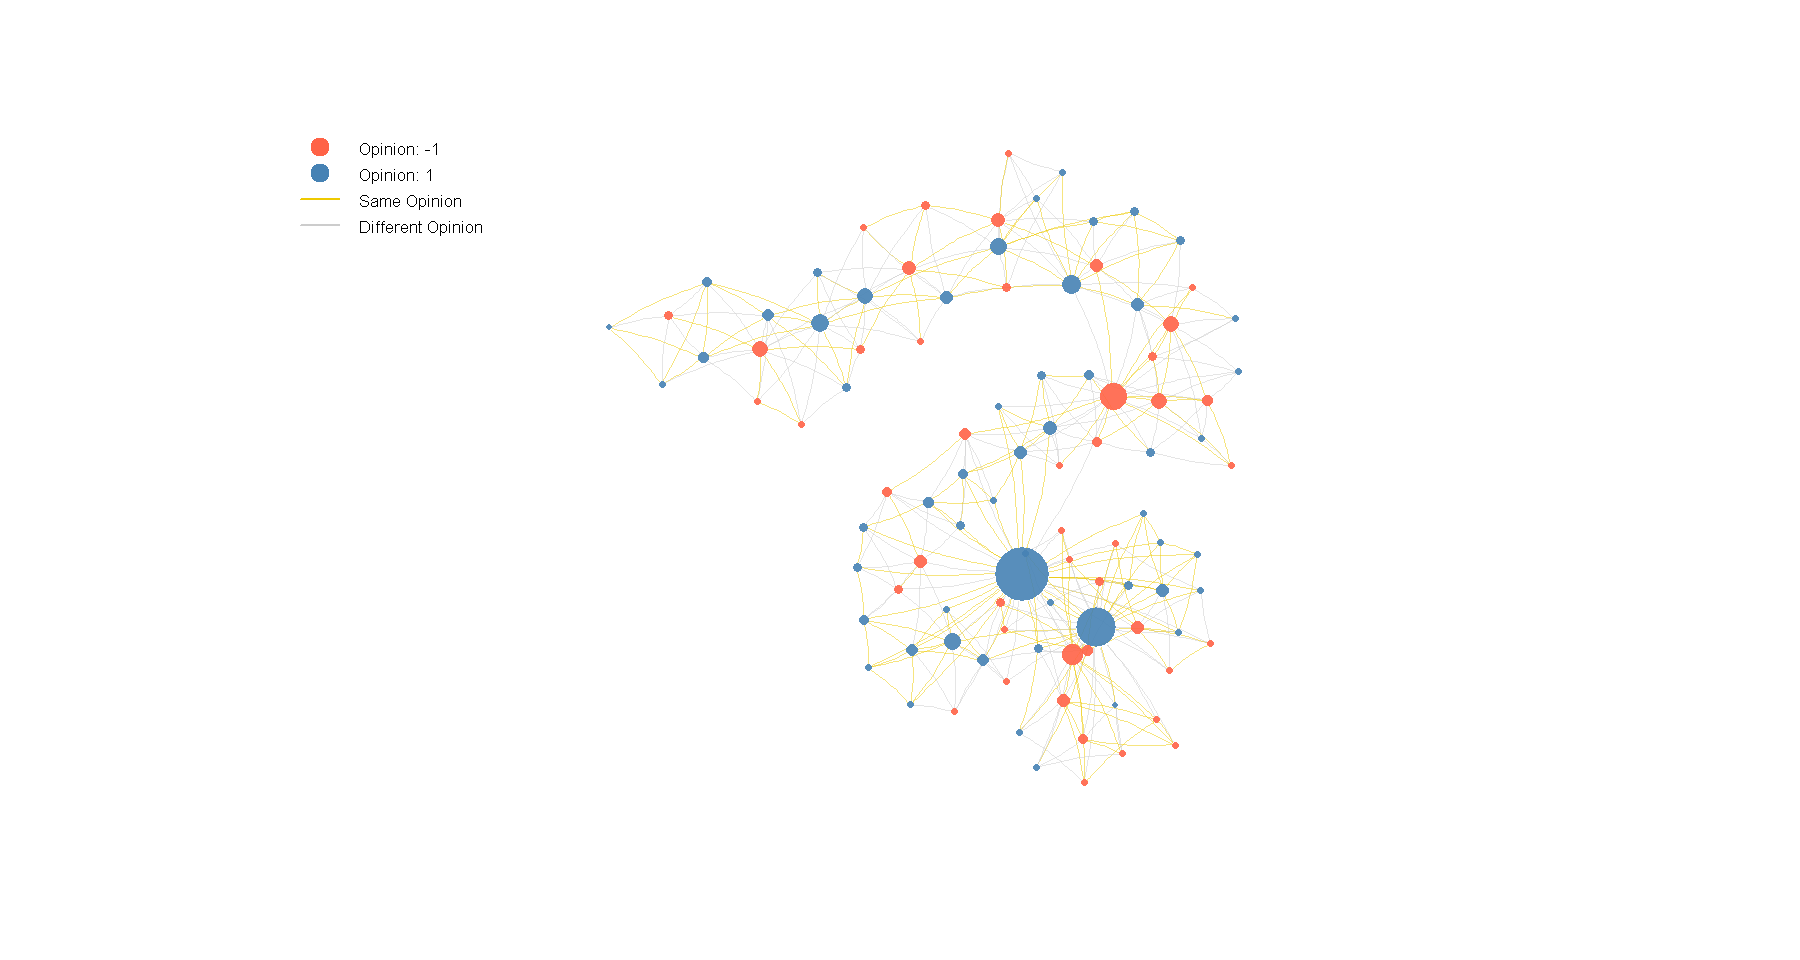

In [676]:
g <- initiate_SSF()

options(repr.plot.width=15, repr.plot.height = 8)
vis_graph(g)

-----------

#### Lattice Plot

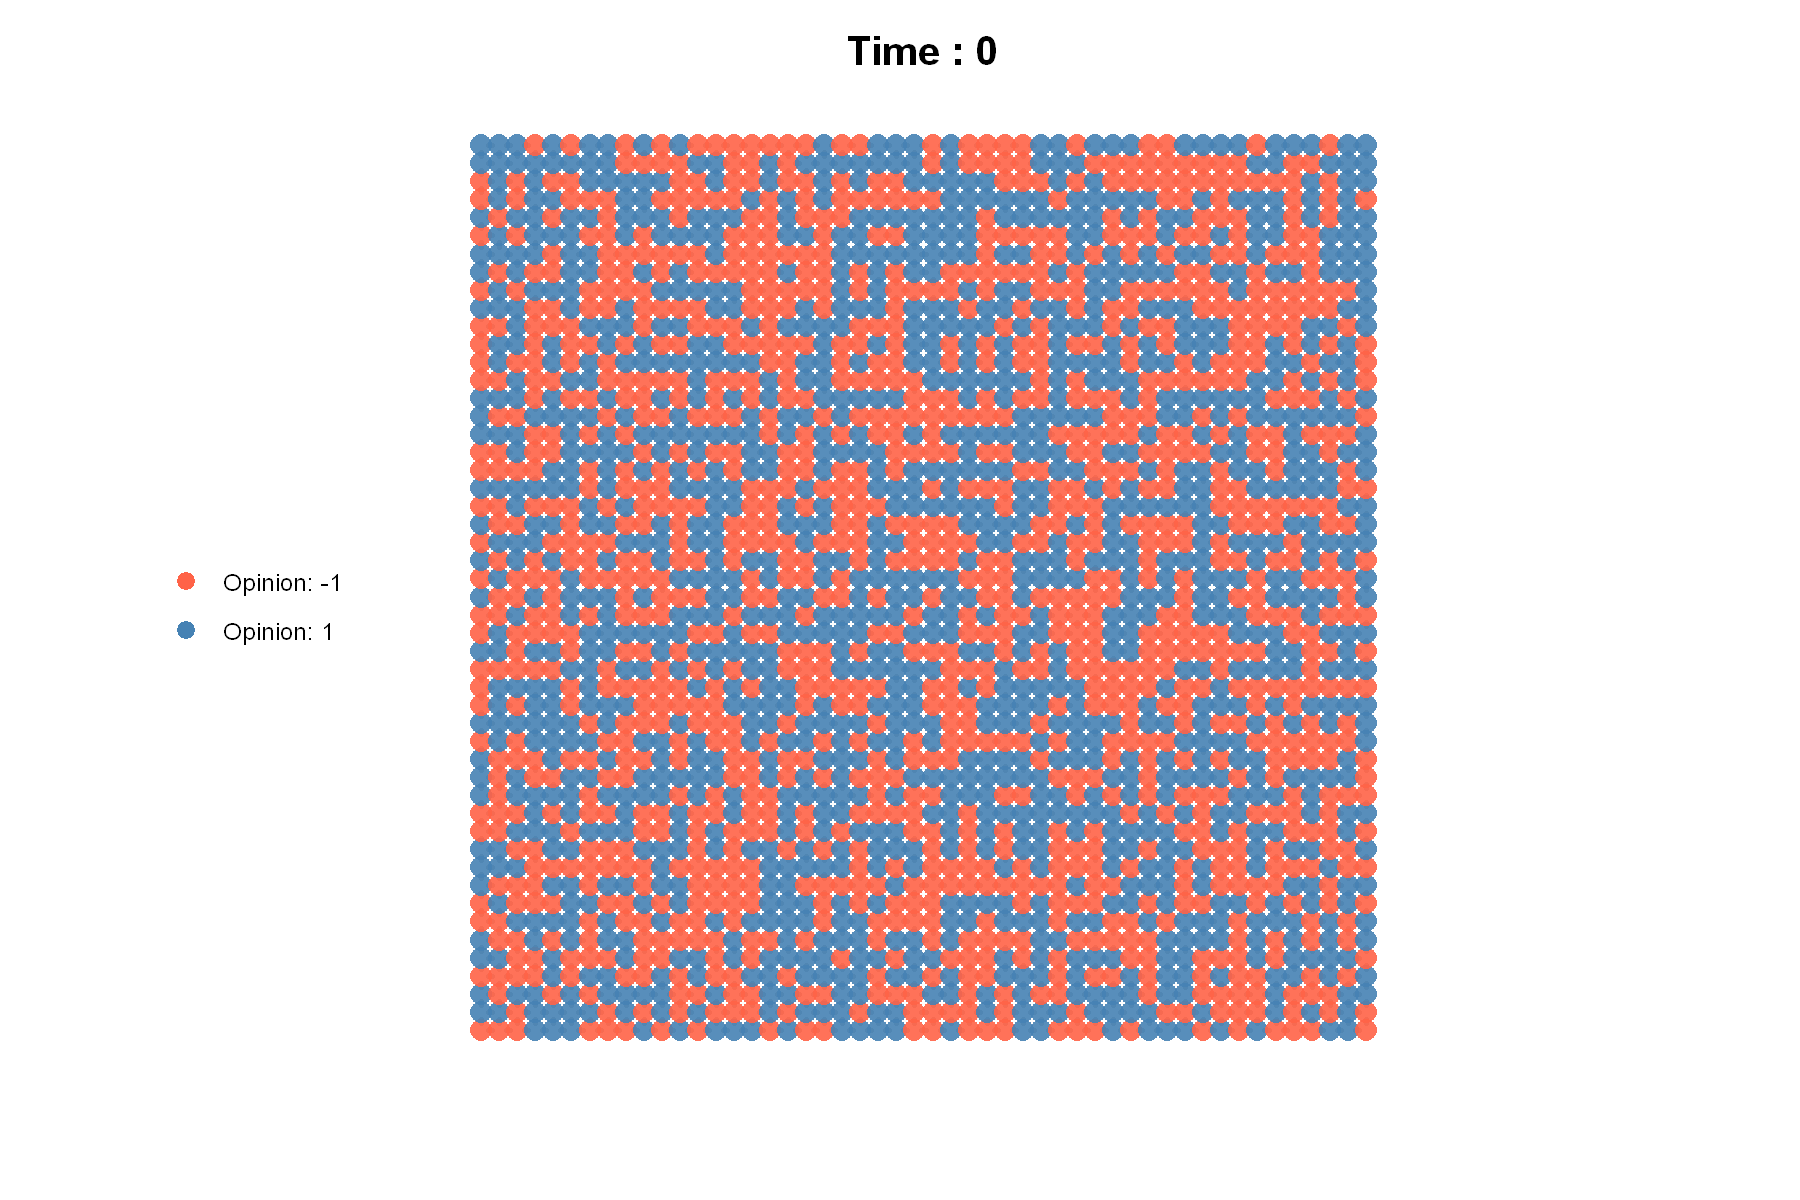

In [672]:
#Plot Lattice Network
vis_lattice <- function(g, plot_title, plot_legend = FALSE){

  #Main Plot
  plot(g,
    layout = layout.grid(g),
    vertex.size = 5,
    vertex.label = NA,
    vertex.color = adjustcolor( unlist(cols[ g$opinion + 1 ]), alpha.f=0.9),
    vertex.frame.color = NA,
    edge.width = 4
    )

  #Plot Legend
  if (plot_legend){
    legend(x = -1.75, y = 0.125, c("Opinion: -1","Opinion: 1"), 
            pch=c(21, 21),
            col= cols, #"#777777", 
            pt.bg= cols, pt.cex=2, cex=1.2, bty="n"
            )
  }

  #Plot Title
  title(main = plot_title, cex.main = 2)
    
}

options(repr.plot.width=15, repr.plot.height=10)

g <- initiate_LAT(d = 2, l = 50)
vis_lattice(g, plot_title = 'Time : 0', plot_legend = TRUE)

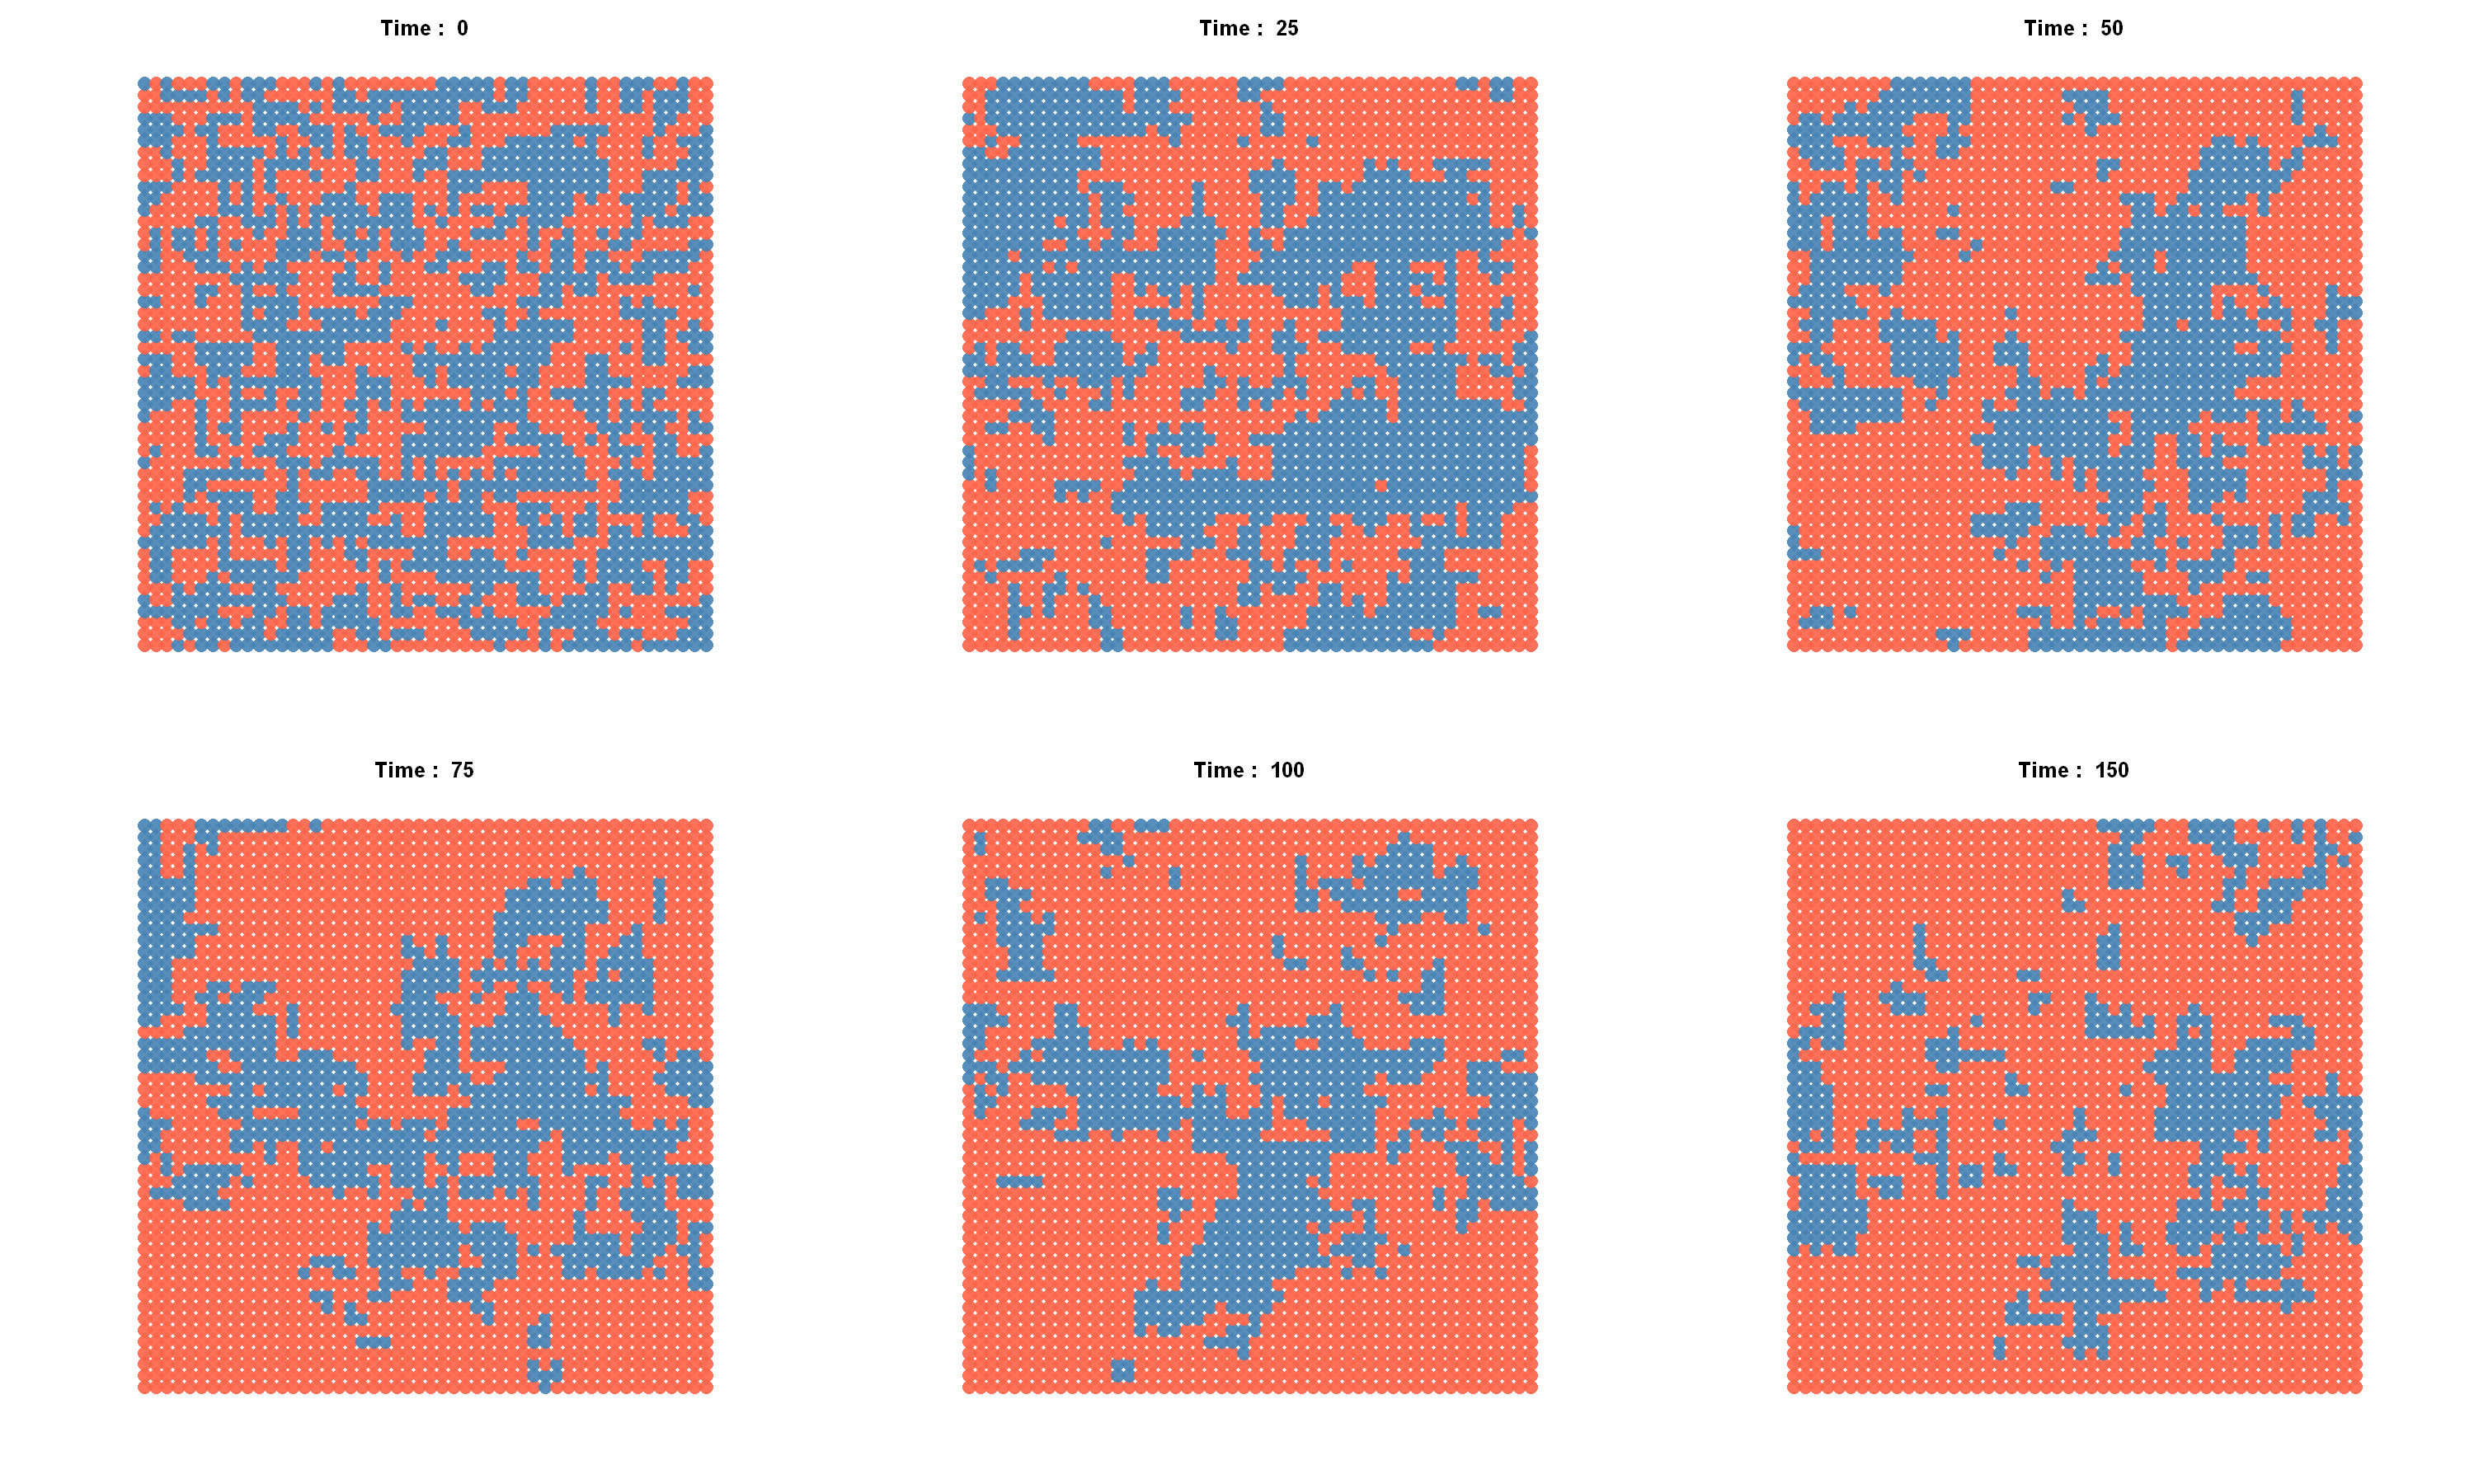

In [673]:
plot_t <- c(0, 25, 50, 75, 100, 150)

g <- initiate_LAT(d = 2, l = 50)

par(mfrow = c(2, 3))
options(repr.plot.width=25, repr.plot.height=15)

for (t in 0:150){

    #For Node Update
    #adj_mat <- as_adjacency_matrix(g,sparse = F)    
    #g <- node_update(g, adj_mat)

    #For Edge Update
    g <- edge_update(g)

    if (t %in% plot_t){
        vis_lattice(g, plot_title = paste('Time : ', t), plot_legend = FALSE)
    }
}

##### Animated Lattice

In [ ]:
# Load necessary libraries
library(animation)

# Set the number of frames and the interval between frames
num_frames <- 500
frame_interval <- 0.1

#Initialize Lattice
g <- initiate_LAT(d = 2, l = 50)

# Create frame with lattice plot
create_frame <- function(g, t) {  
  vis_lattice(g, plot_title = paste('Time : ', t), plot_legend=FALSE)
}

# Create and save the animated GIF
saveGIF({

    for (t in 0:num_frames){
        create_frame(g, t)
        g <- edge_update(g)        
    }

}, movie.name = "animated_lattice_check.gif", interval = frame_interval)


Output at: animated_lattice_500.gif



[1] TRUE

#### Rho Plots

In [12]:
get_df_full <- function(path){

    #List of all files
    list_files <- list.files(path = path, pattern='mode.*.csv', full.names=T)

    #Get the dataframe corresponding to each file
    df_files <- lapply(list_files, read.csv)

    #For each dataframe, add in the D, N, mode parameter information
    for (i in 1:length(df_files)){
        file <- df_files[[i]]
        colnames(file) <- c('t', 'rho')
        file_len <- length(file$t)

        #Splits the file name to obtain the params, param names
        split_name <- gsub('.csv', '', list_files[i]) 
        split_name <- gsub('VM_.?/', '', split_name)

        name_len <- length(strsplit(split_name, ' ')[[1]])

        params <- unlist(strsplit(split_name, ' '))[seq(2, name_len, 2)]
        param_names <- unlist(strsplit(split_name, ' '))[seq(1, name_len, 2)]
        names(params) <- param_names

        #Creates tibble of params in the same length of the file df
        df_params <- as_tibble(t(params))
        df_params <- bind_rows(replicate(length(file$t), df_params[1,], simplify=F))

        #Column binds file, df_params
        file <- bind_cols(file, df_params)    

        #Updates the file df
        df_files[[i]] <- file

        #print(paste('Finished', i))
    }

    #Concatenate all df into one df_full
    df_full <- df_files[[1]]

    for (i in 2:length(df_files)){
        df_full <- rbind(df_full, df_files[[i]])
    }

    return (df_full)

}

path = 'VM_0/'
df_full <- get_df_full(path) 

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


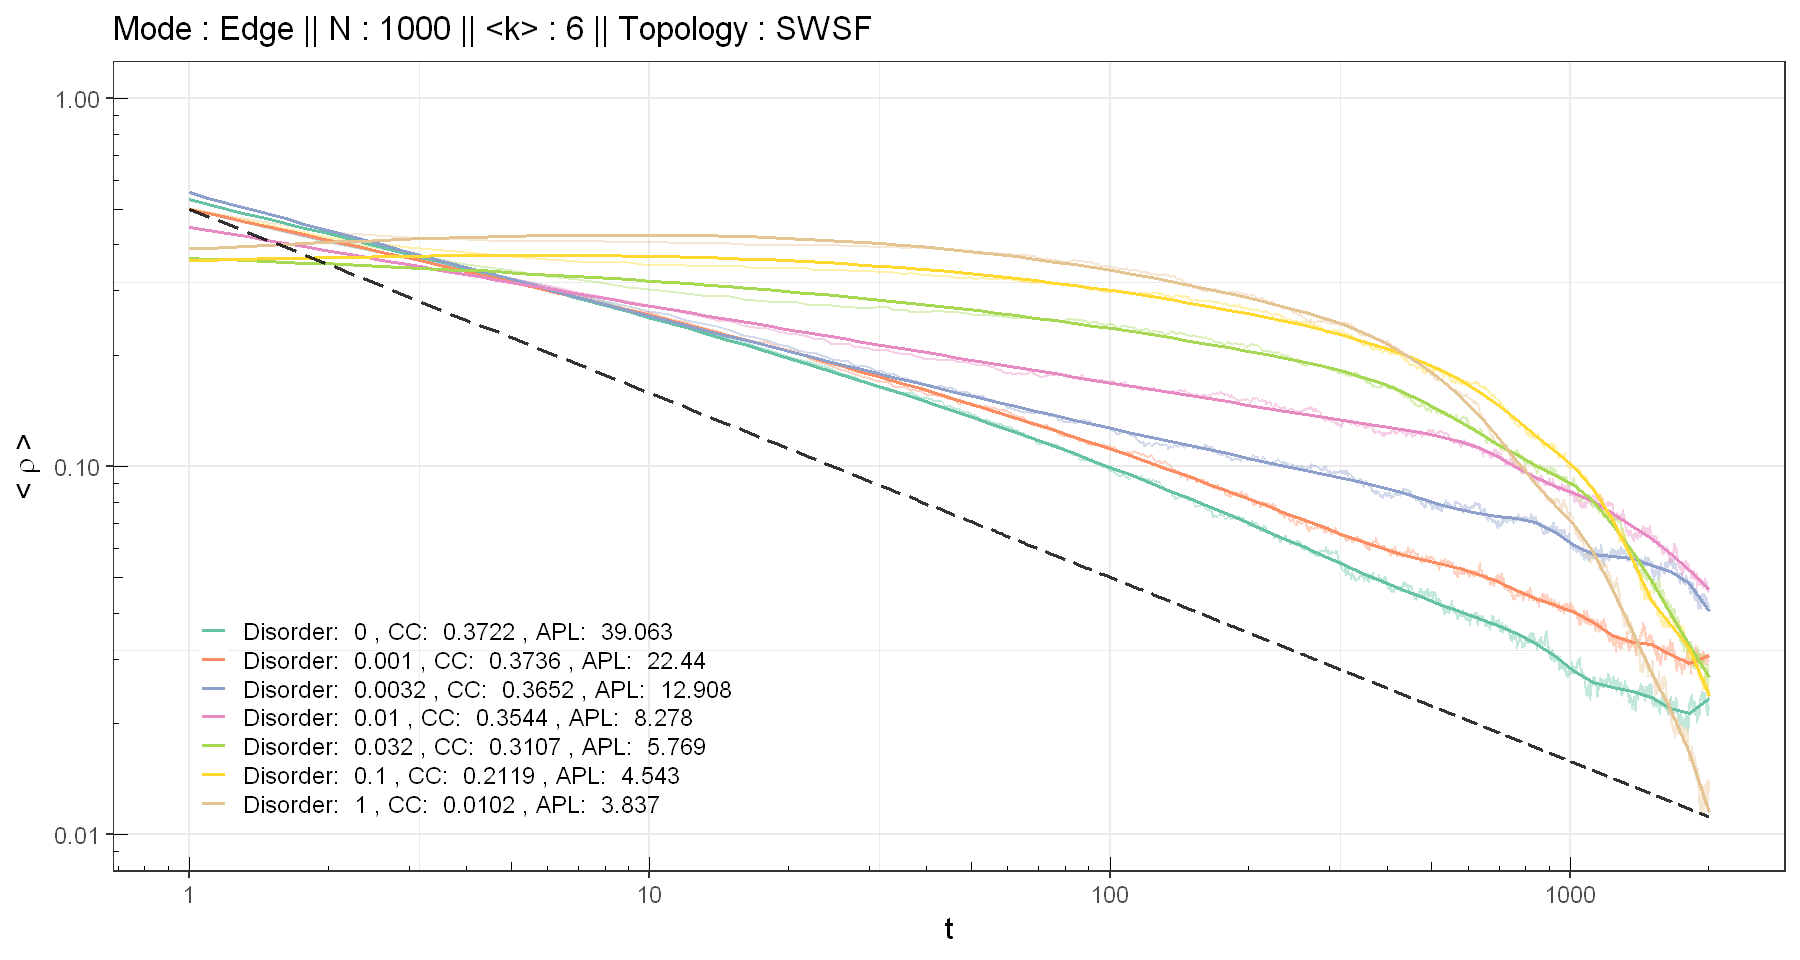

In [13]:
plot_rho_var_p <- function(df_full){

    df_fil <- df_full %>% 
                mutate(ref_line = 0.5 * t^(-0.5)) %>%   #Adds reference column for plotting dotted line (t^(-0.5))
                mutate(concat_labels = paste('Disorder: ', disorder, ', CC: ', round(as.double(CC), 4), ', APL: ', round(as.double(APL), 3)))   #Adds label column

    #Factorize and define levels
    factorize_param <- 'concat_labels'

    #Plot Title
    plot_title <- 'Mode : Edge || N : 1000 || <k> : 6 || Topology : SWSF'
    legend_title <- 'Params'


    #Plotting
    options(repr.plot.width=15, repr.plot.height=8)
    colors_req <- length(unique(df_fil[[factorize_param]]))

    ggplot(df_fil) +
        geom_line(aes(t, rho, col=get(factorize_param)), lwd=.6, alpha=.4) +
        geom_smooth(aes(t, rho, col=get(factorize_param)), alpha=0) +

        geom_line(aes(t, ref_line), linetype = 'longdash', size=1, alpha=0.8) +


        #Define theme
        theme_bw(base_size = 18) +
        theme(plot.title = element_text(size=20),
                legend.position = c(0.21, 0.2),
                legend.background = element_rect(fill='transparent')) +

        #Scale Axes
        scale_x_log10() +
        scale_y_log10(limits = c(1e-2, 1)) +
        annotation_logticks() +

        #Axis Labels
        xlab(TeX(r'($t$)')) +
        ylab(TeX(r'(< $\rho$ >)')) + 

        #Legend 
        scale_color_manual(
            values = brewer.pal(n=colors_req, name='Set2'),
            #labels=c('SWSF', 'SW'),
            name=NULL,#legend_title
        ) +

        #Plot Title
        ggtitle(plot_title)

}

path = 'VM_1_new/'
df_full <- get_df_full(path)

plot_rho_var_p(df_full)

Warning message in brewer.pal(n = colors_req, name = "Set2"):
"minimal value for n is 3, returning requested palette with 3 different levels
"
Warning message in brewer.pal(n = colors_req, name = "Set2"):
"minimal value for n is 3, returning requested palette with 3 different levels
"
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


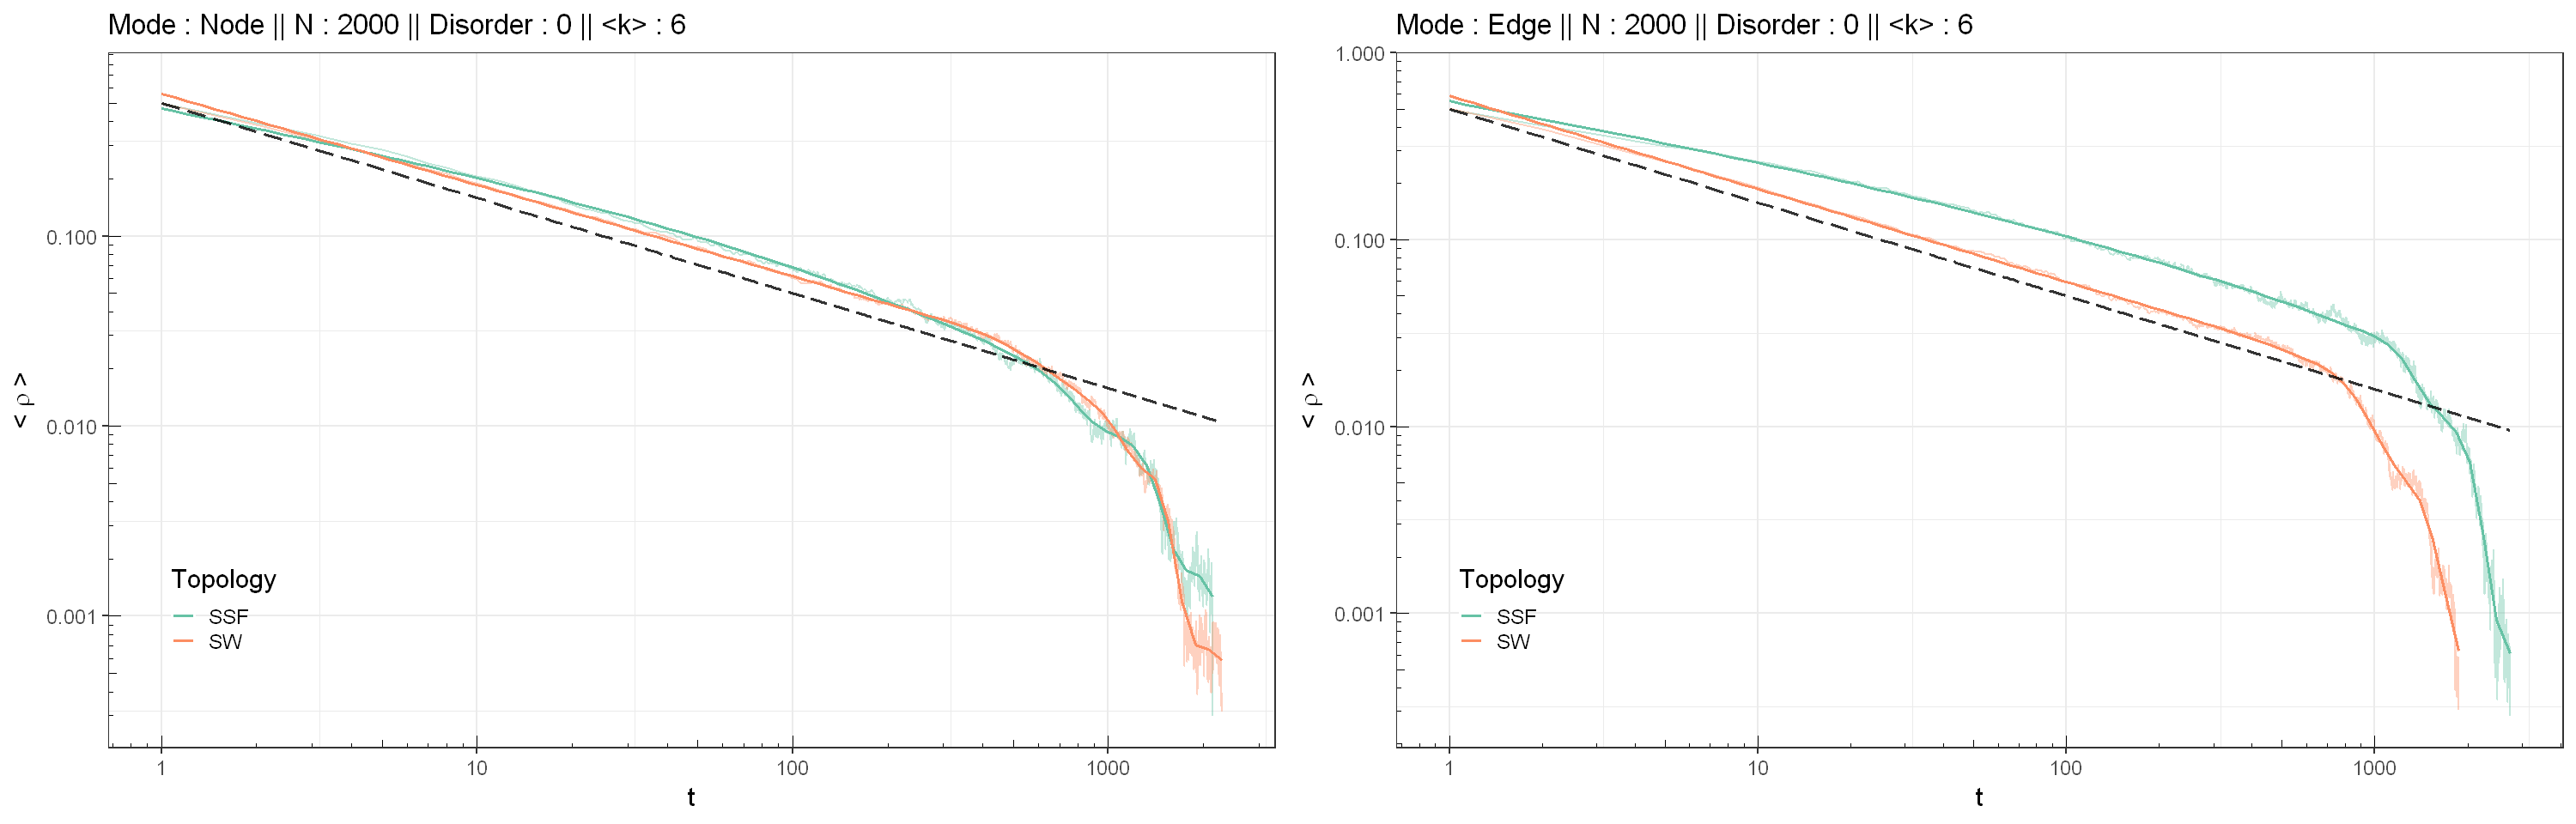

In [629]:
#Plot for Varying Topologies
plot_rho_var_top <- function(df_full, mode_val){

    if ( !(mode_val %in% c('node', 'edge')) ) {
        return ('Invalid Entry:  Please Enter from the following - mode_val = [node, edge]')
    }

    #Filter to mode_val
    df_fil <- df_full %>% filter(mode == mode_val)

    #Adds reference column for plotting dotted line (t^(-0.5))
    df_fil <- df_fil %>% mutate(ref_line = 0.5 * t^(-0.5))

    #Factorize and define levels
    factorize_param <- 'top'

    #Plot Title
    plot_title <- ifelse(mode_val == 'edge', 'Mode : Edge || N : 2000 || Disorder : 0 || <k> : 6', 'Mode : Node || N : 2000 || Disorder : 0 || <k> : 6')
    legend_title <- 'Topology'


    #Plotting
    colors_req <- length(unique(df_fil[[factorize_param]]))

    main_plot <- ggplot(df_fil) +
                    geom_line(aes(t, rho, col=get(factorize_param)), lwd=.6, alpha=.4) +
                    geom_smooth(aes(t, rho, col=get(factorize_param)), alpha=0) +

                    geom_line(aes(t, ref_line), linetype = 'longdash', size=1, alpha=0.8) +


                    #Define theme
                    theme_bw(base_size = 18) +
                    theme(plot.title = element_text(size=20),
                            legend.position = c(0.1, 0.2),
                            legend.background = element_rect(fill='transparent')) +

                    #Scale Axes
                    scale_x_log10() +
                    scale_y_log10() +
                    annotation_logticks() +

                    #Axis Labels
                    xlab(TeX(r'($t$)')) +
                    ylab(TeX(r'(< $\rho$ >)')) + 

                    #Legend 
                    scale_color_manual(
                        values = brewer.pal(n=colors_req, name='Set2'),
                        #labels=c('SWSF', 'SW'),
                        name=legend_title
                    ) +

                    #Plot Title
                    ggtitle(plot_title)

    return(main_plot)

}

mode_val <- 'edge'

#Plot Individually
# options(repr.plot.width=15, repr.plot.height=8)
# plot_rho_top(df_full, mode_val)


# #Plot in Grid
mode_vals <- c('node', 'edge')
plot_grid(df_full, plot_rho_var_top, mode_vals)

In [50]:
#Get the slope of linear region

only_consider_region <- 500

check <- df_full %>% 
            filter(mode == 'edge' & top == 'SW') %>%   #Filters to unique params
            filter(t < only_consider_region) %>%        #Filters to region with linear behaviour
            mutate(t = log(t), rho = log(rho))          #Converts to log values

fit <- lm(check$rho ~ check$t)      #Linear Fit

slope <- coef(fit)['check$t']       #Get slope from fit
cat(paste('Slope: ', unname(slope)))

Slope:  -0.497817700133172

#### Xi, Tau Plots

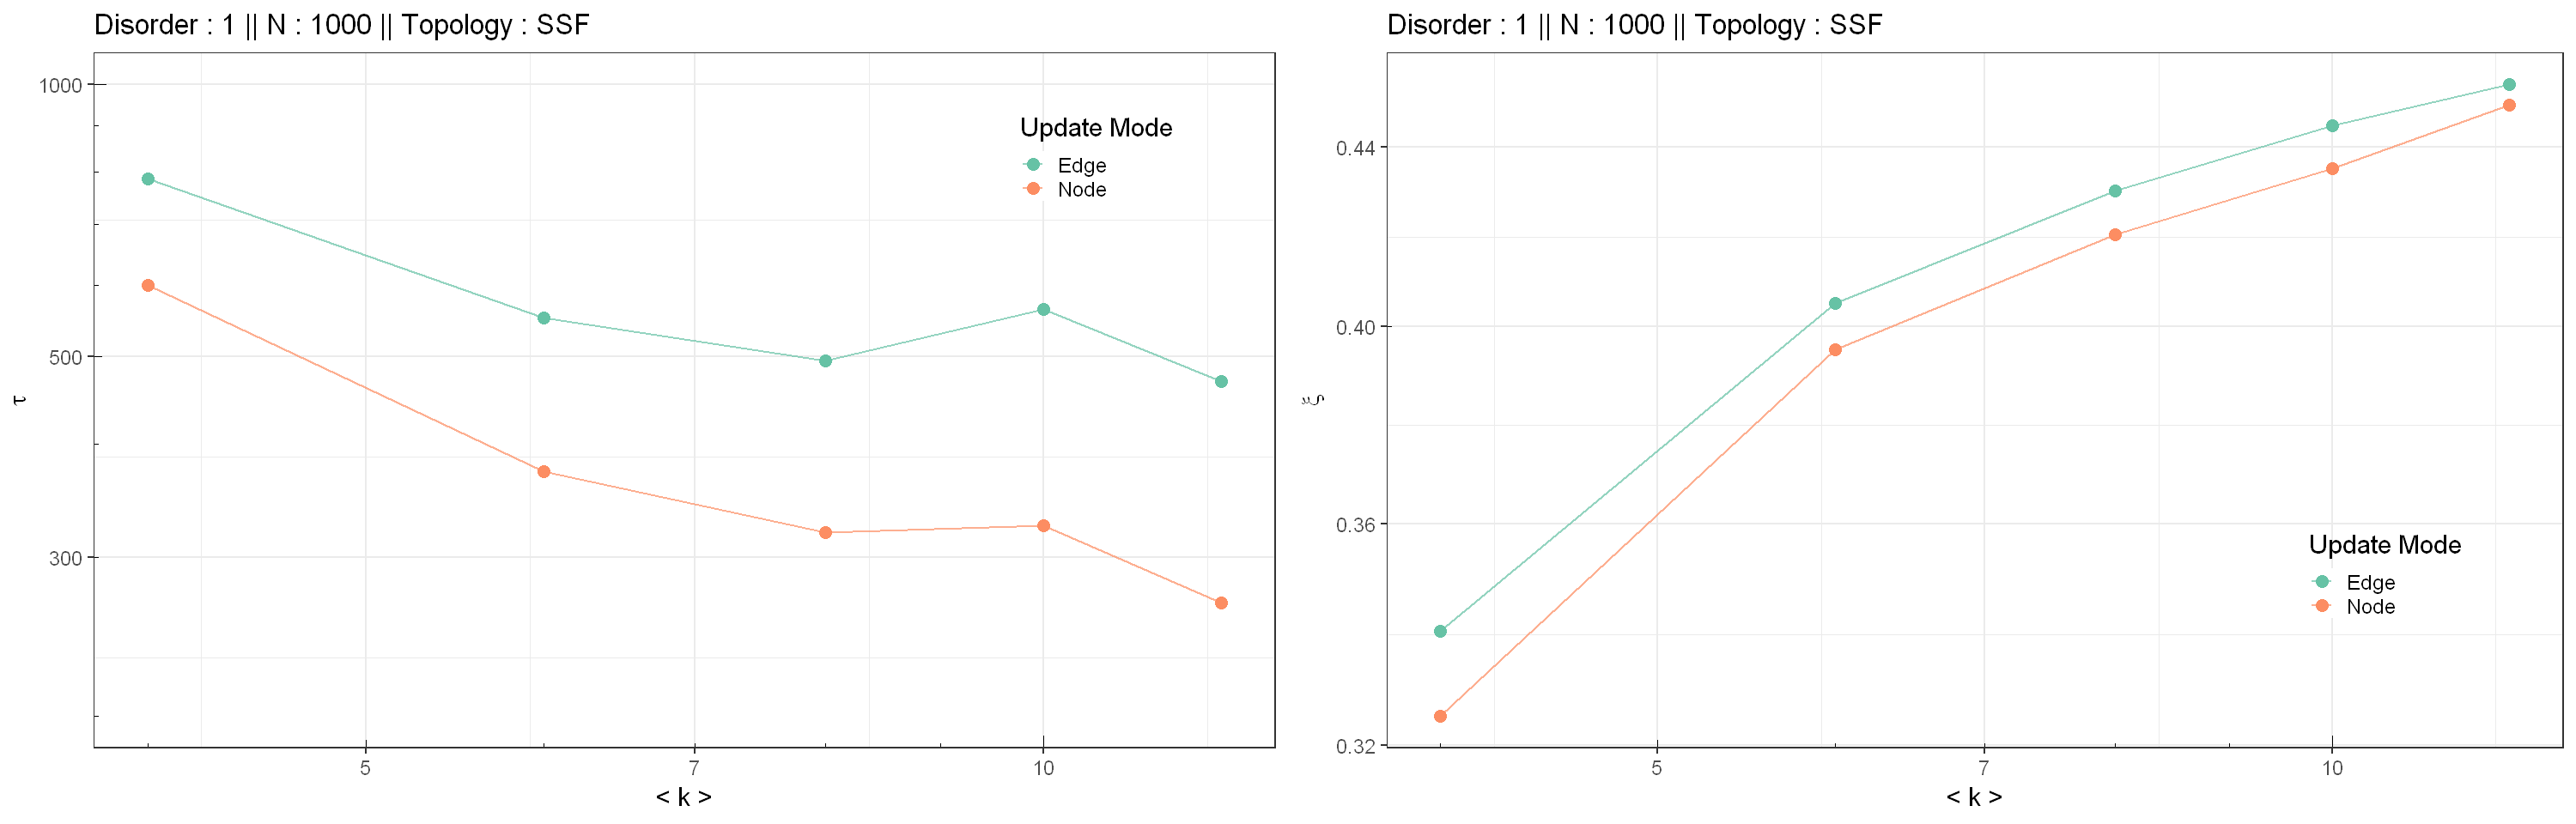

In [657]:
#Plot against varying <k> value
plot_var_k <- function(df, plot_param){

    if ( !(plot_param %in% c('Tau', 'xi')) ) {
        return ('Invalid Entry:  Please Enter from the following - plot_param = [Tau, xi]')
    }

    plot_title <- 'Disorder : 1 || N : 1000 || Topology : SSF'
    legend_title <- 'Update Mode'

    main_plot <- ggplot(df, aes(k, get(plot_param), col = mode)) +
                    geom_point(size=4) +
                    geom_line(alpha=.7, lwd=.8) +

                    #Define theme
                    theme_bw(base_size = 18) +
                    theme(plot.title = element_text(size=20),
                            legend.background = element_rect(fill='transparent')) +

                    #Scale Axes
                    scale_x_log10() +
                    annotation_logticks() +

                    #Axis Labels
                    xlab(TeX(r'(< $k$ >)')) +
                    ylab(ifelse(plot_param == 'xi', TeX(r'($\xi$)'), TeX(r'($\tau$)'))) + 

                    #Legend 
                    scale_color_manual(
                        values = brewer.pal(n=3, name='Set2'),
                        labels = c('Edge', 'Node'),
                        name= legend_title
                    ) +

                    #Plot Title
                    ggtitle(plot_title)

    #Fix Legend Position
    if (plot_param == 'xi'){
        main_plot <- main_plot + 
                        theme(legend.position = c(0.85, 0.25)) +
                        scale_y_log10()
    }
    else {
        main_plot <- main_plot + 
                        theme(legend.position = c(0.85, 0.85)) +
                        scale_y_log10(limits = c(200, 1e3))
    }

    return(main_plot)
}

#Reading file
path <- 'VM_2/table.csv'
file <- read.csv(path)

#Parameters for plotting
plot_param <- 'Tau'     # Tau / xi

#Plot Individually
# options(repr.plot.width=15, repr.plot.height = 8)
# plot_var_k(file, plot_param)

#Plot in Grid
param_vals <- c('Tau', 'xi')
plot_grid(file, plot_func = plot_var_k,     
                param_0_vals = param_vals)

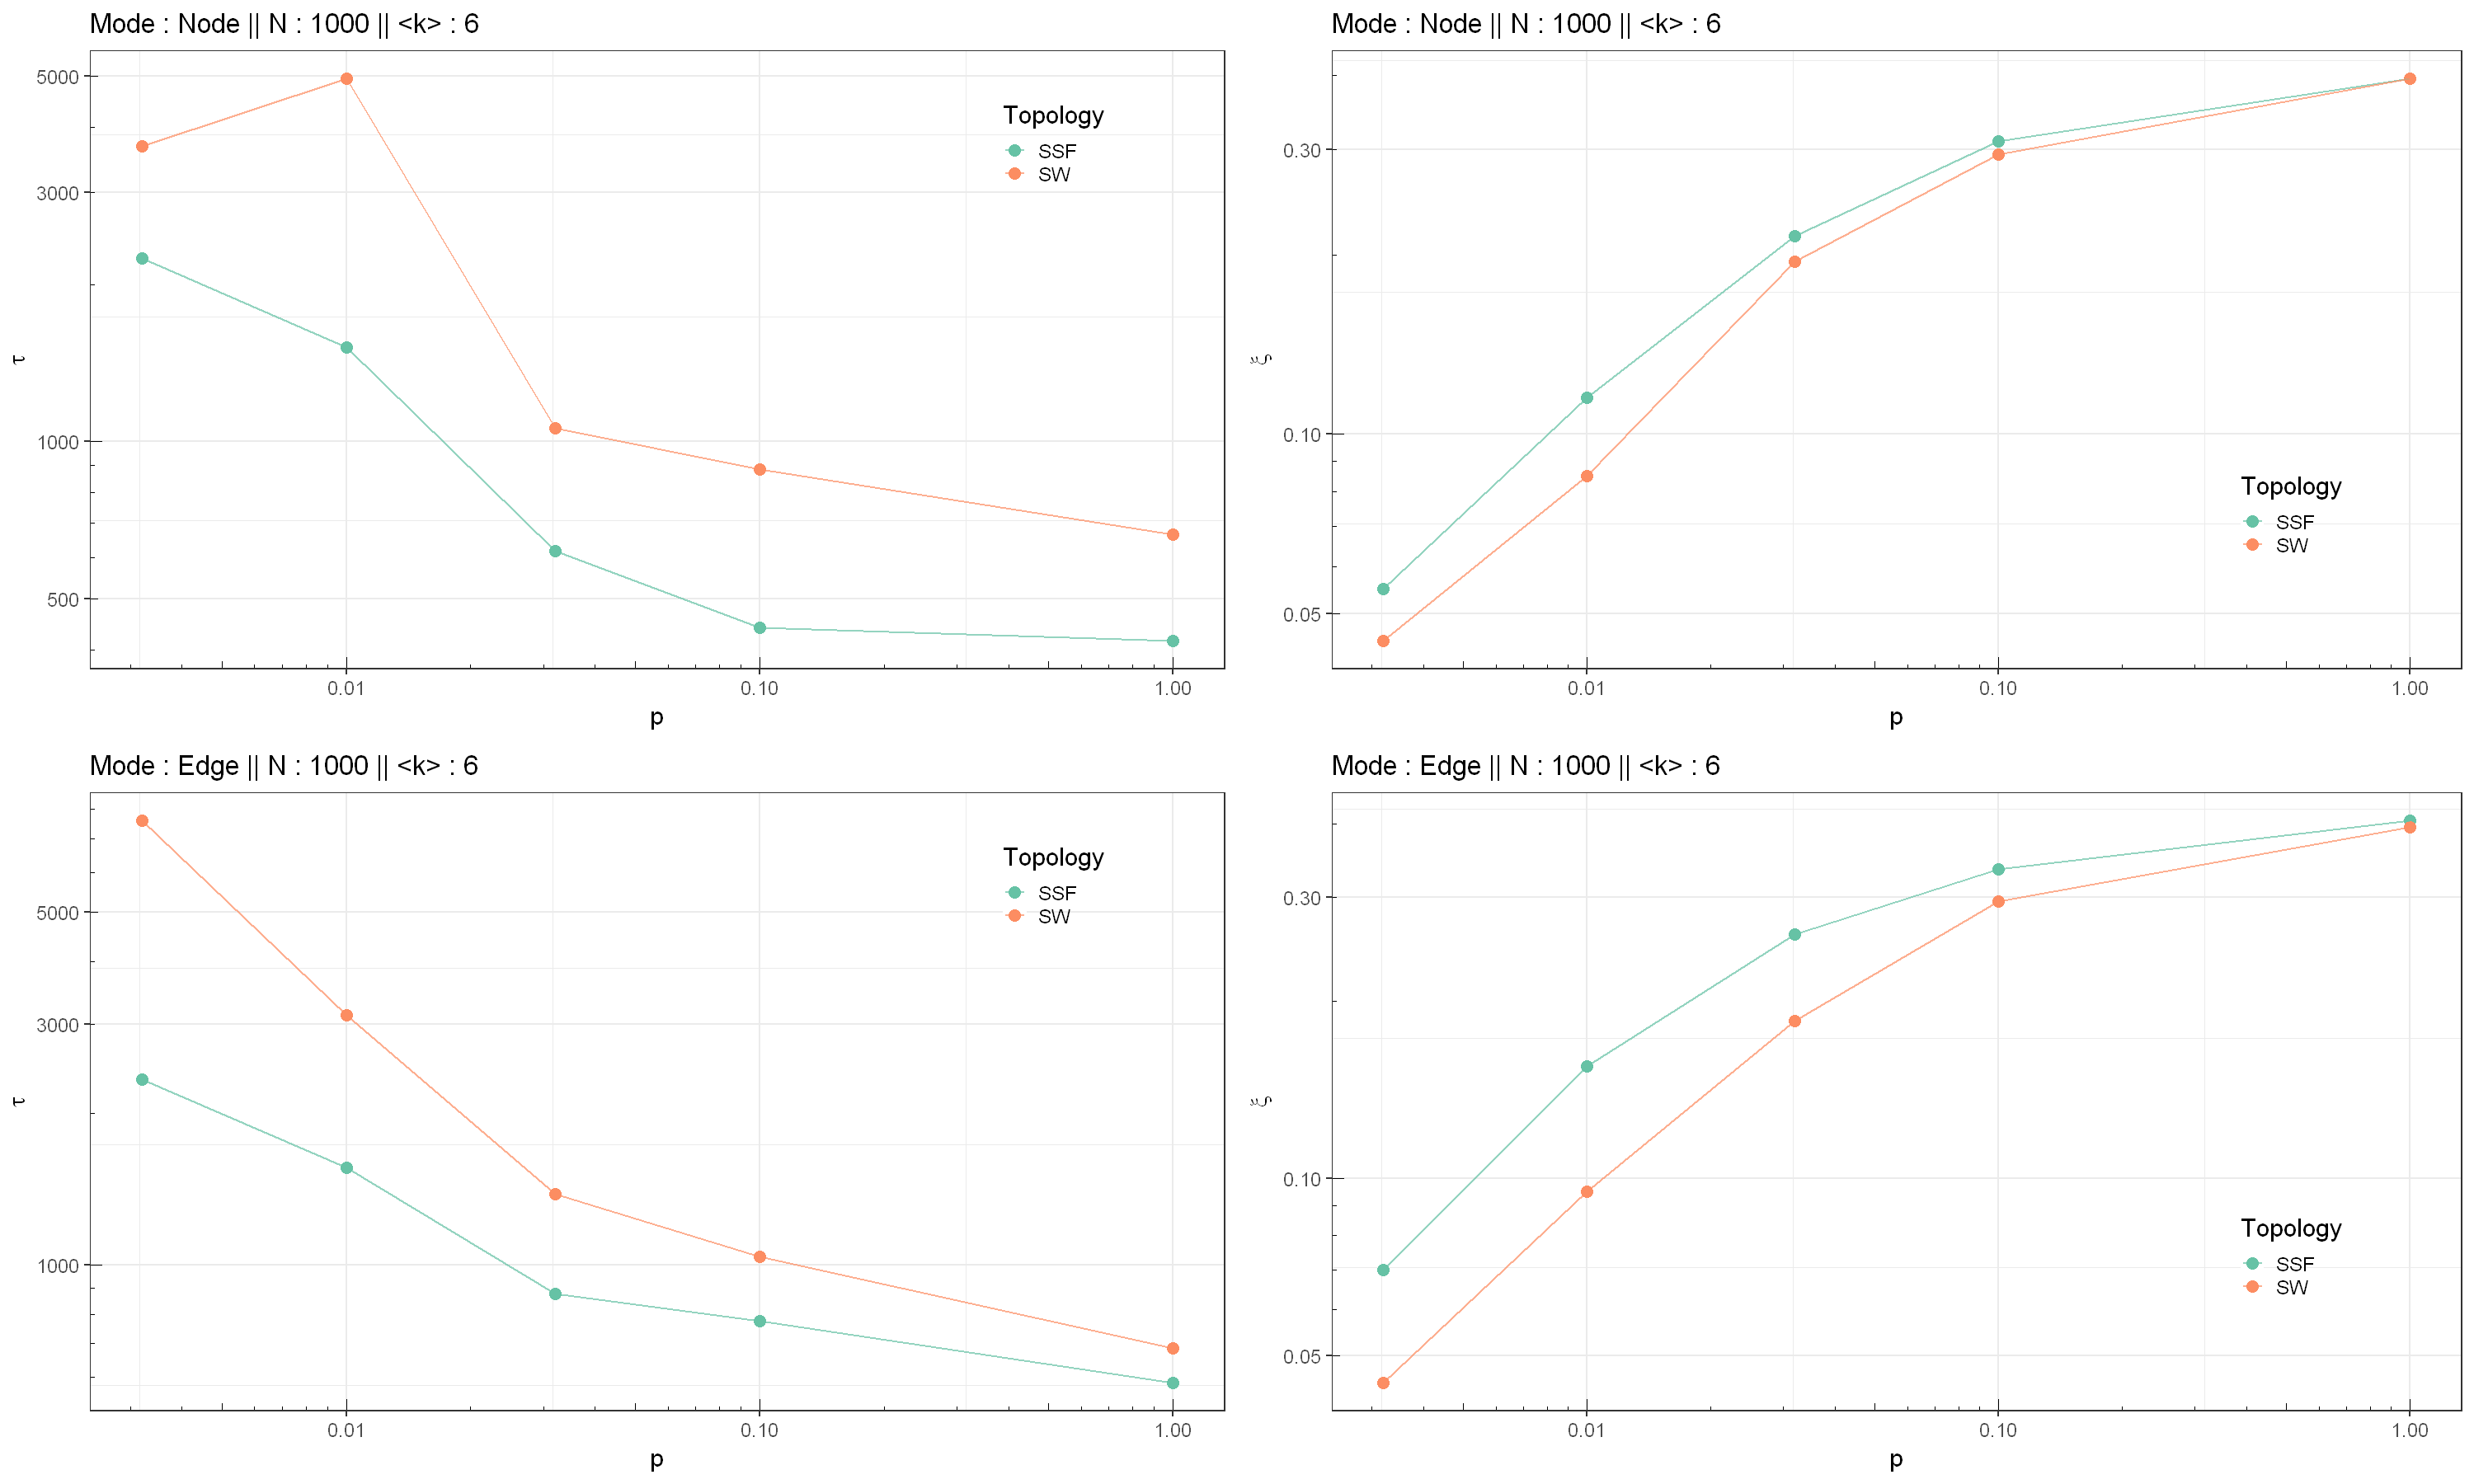

In [662]:
#Plot against varying disorder / p value
plot_var_p <- function(df, mode_val, plot_param){

    if ( !(mode_val %in% c('node', 'edge')) | !(plot_param %in% c('Tau', 'xi')) ) {
        return ('Invalid Entry:  Please Enter from the following - model_val = [node, edge], plot_param = [Tau, xi]')
    }

    df$disorder[df$disorder == 0] <- 0.00001
    df$disorder[df$disorder == 2] <- 1

    plot_title <- ifelse(mode_val == 'node', 'Mode : Node || N : 1000 || <k> : 6', 'Mode : Edge || N : 1000 || <k> : 6')
    legend_title <- 'Topology'

    #Filter to mode_val
    df_fil <- df %>% filter(mode == mode_val)


    main_plot <- ggplot(df_fil, aes(disorder, get(plot_param), col = top)) +
                    geom_point(size=4) +
                    geom_line(alpha=.7, lwd=.8) +

                    #Define theme
                    theme_bw(base_size = 18) +
                    theme(plot.title = element_text(size=20),
                            legend.background = element_rect(fill='transparent')) +

                    #Scale Axes
                    scale_x_log10() +
                    scale_y_log10() +
                    annotation_logticks() +

                    #Axis Labels
                    xlab('p') +
                    ylab(ifelse(plot_param == 'xi', TeX(r'($\xi$)'), TeX(r'($\tau$)'))) + 

                    #Legend 
                    scale_color_manual(
                        values = brewer.pal(n=3, name='Set2'),
                        name= legend_title
                    ) +

                    #Plot Title
                    ggtitle(plot_title)

    #Fix Legend Position
    if (plot_param == 'xi'){
        main_plot <- main_plot + theme(legend.position = c(0.85, 0.25))
    }
    else {
        main_plot <- main_plot + theme(legend.position = c(0.85, 0.85))
    }

    return(main_plot)
}

#Reading file
path <- 'VM_0/table.csv'
file <- read.csv(path)

#Parameters for plotting
mode_val <- 'node'
plot_param <- 'Tau'

#Plot individually
# options(repr.plot.width=15, repr.plot.height = 8)
# plot_var_p(file, mode_val, plot_param)


#Plot in Grid
mode_vals <- c('node', 'edge')
param_vals <- c('Tau', 'xi')

plot_grid(file, plot_func = plot_var_p,     
                param_0_vals = mode_vals,
                param_1_vals = param_vals)

Mode:  node  Top:  SSF  -> Exponent:  0.994891906902801 , Factor:  0.393519826608849

Mode:  node  Top:  SW  -> Exponent:  0.97184975701183 , Factor:  0.769332947335342

Mode:  edge  Top:  SSF  -> Exponent:  1.04593352295054 , Factor:  0.398449982872379

Mode:  edge  Top:  SW  -> Exponent:  0.931598767031237 , Factor:  1.01930233295553



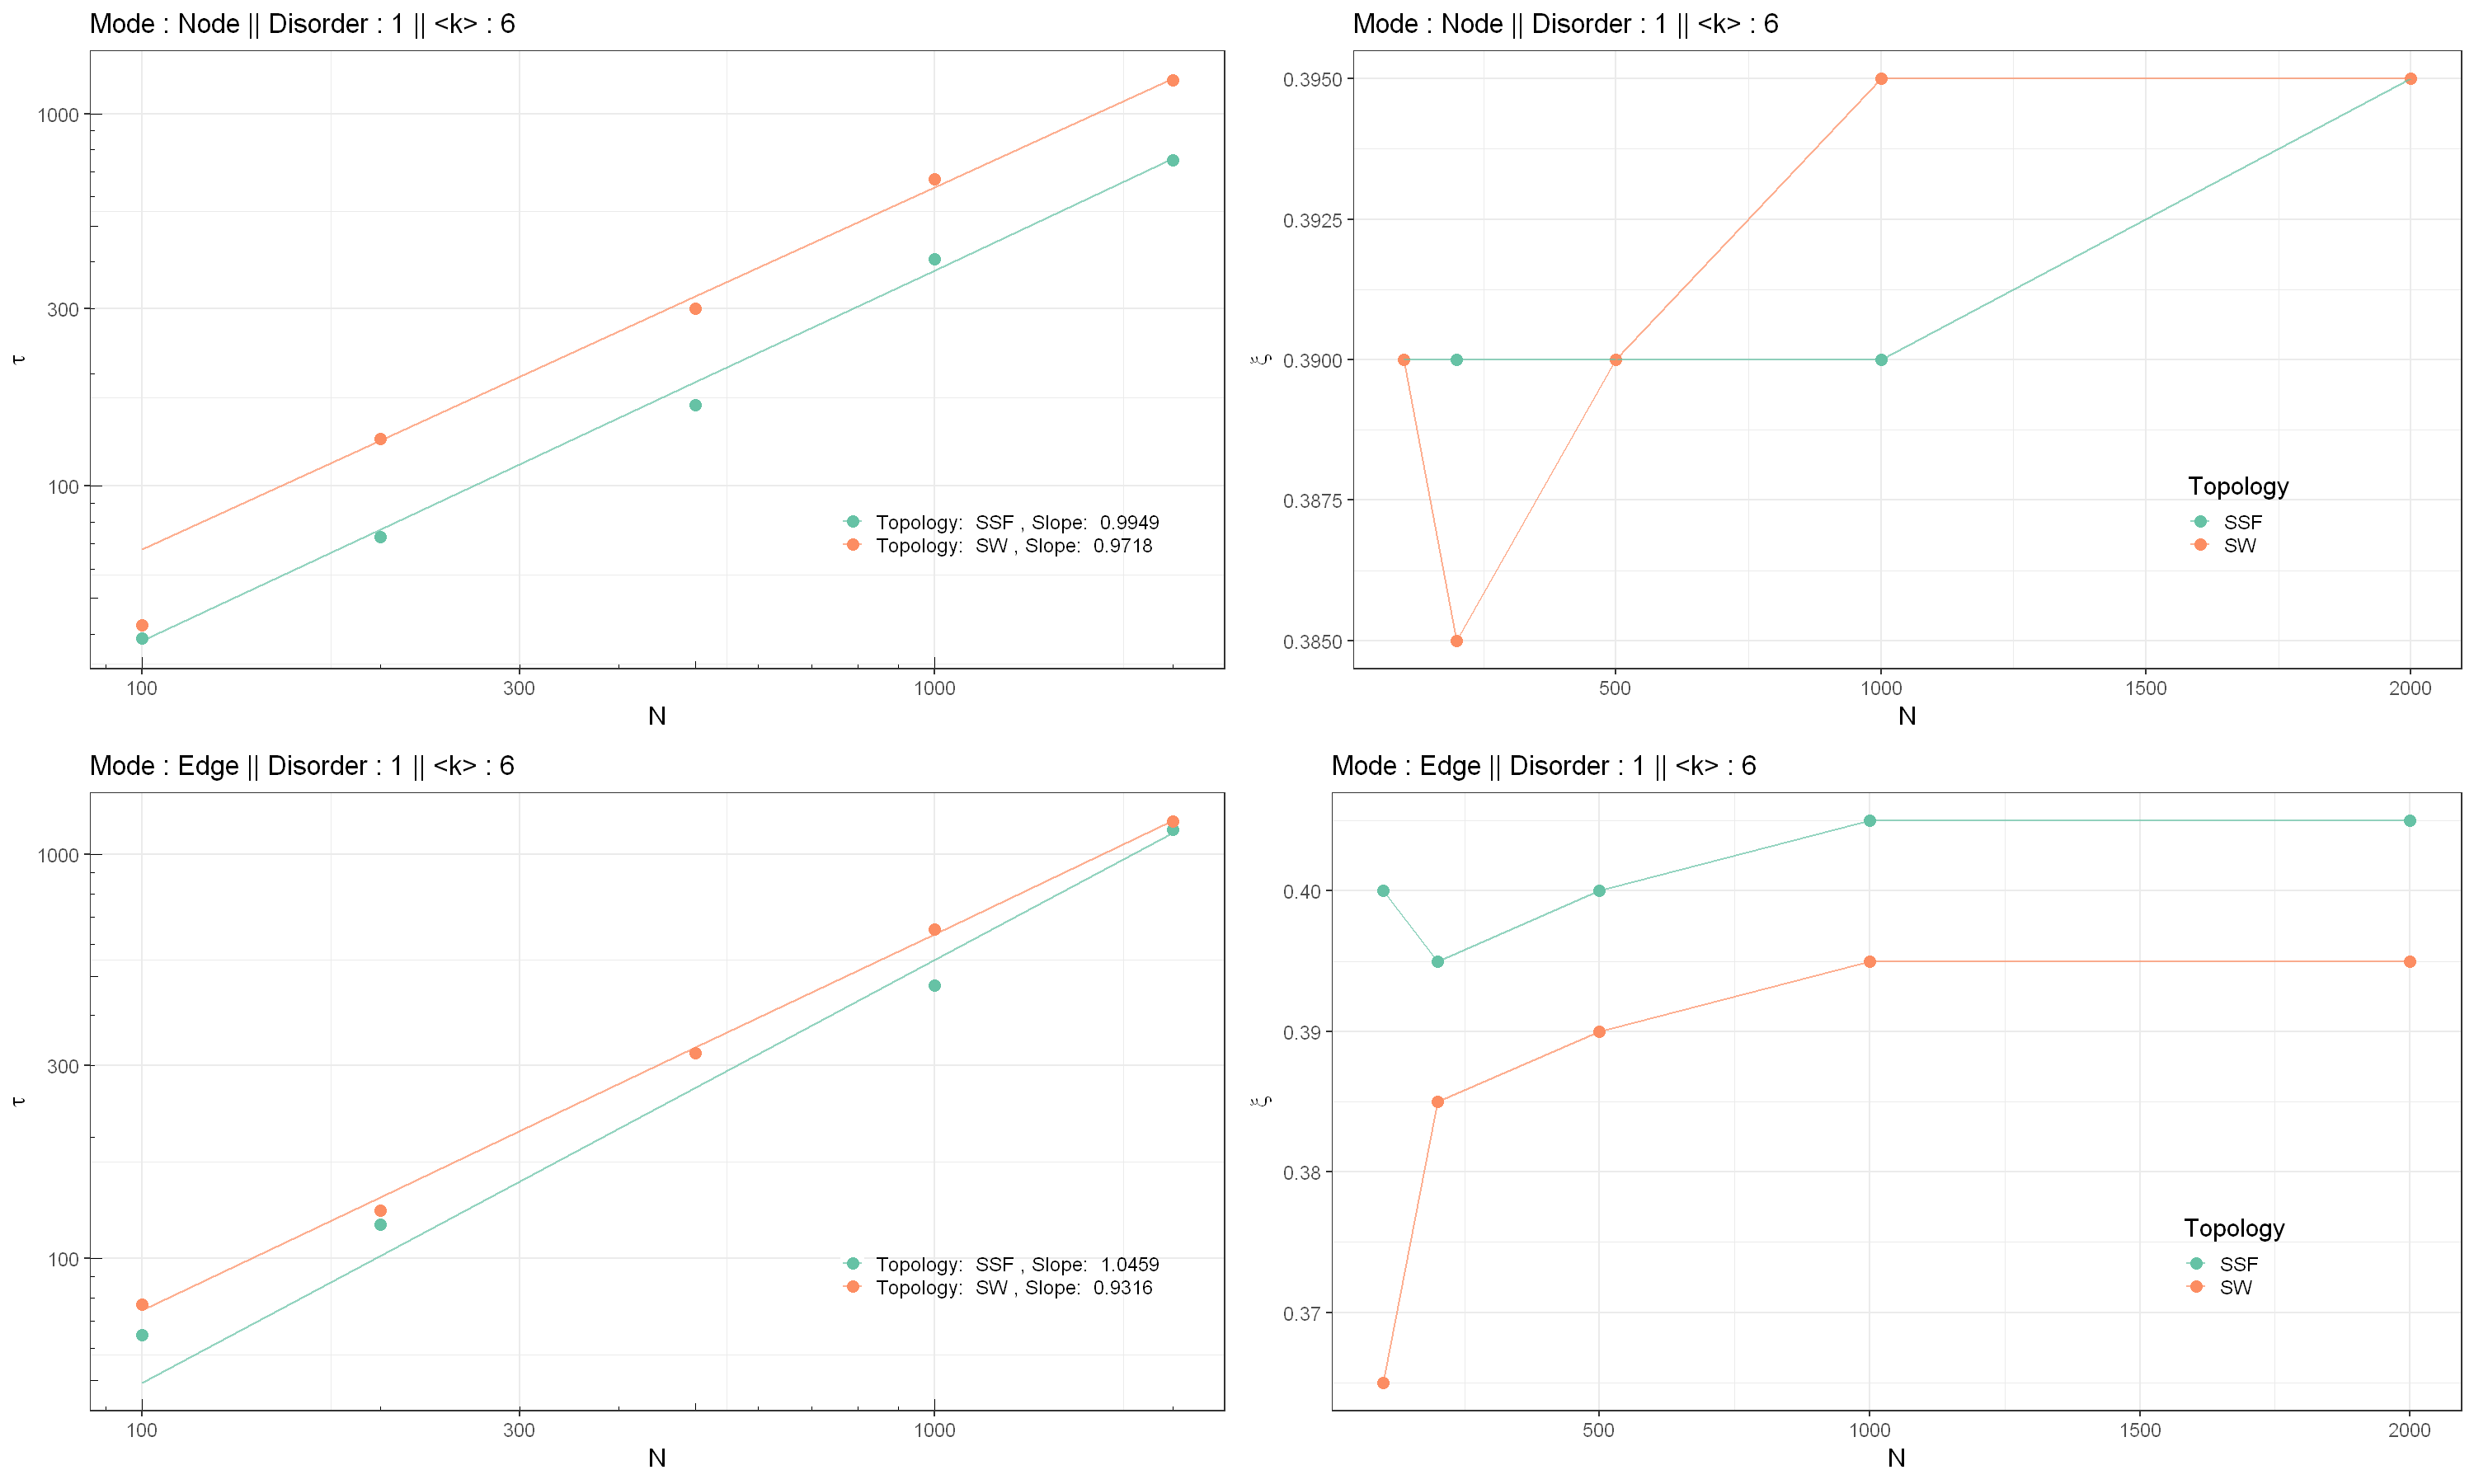

In [663]:
#Implement exponential fit to get factor, exponent values
get_fit_func <- function(df, mode_val, top_val){

    #Filtering to mode_val, topology val
    df_fil <- df %>% 
                filter(mode == mode_val & top == top_val)   #Filters to unique params

    #Implement exponential fit to get factor, exponent
    fit <- nls(Tau ~ a * N^(b), data = df_fil, start = list(a = 1, b = 1))

    exponent <- unname(coef(fit)[2])       #Get slope from fit
    factor <- unname(coef(fit)[1])   #Get intercept

    #Define function with factor, exponent
    func <- function(x) factor * ( x ^ exponent )

    message(paste('Mode: ', mode_val, ' Top: ', top_val, ' -> Exponent: ', exponent, ', Factor: ', factor))
    
    return (c(func, exponent))
}

#Plot against varying N
plot_var_N <- function(df,mode_val, param_val){

    if ( !(mode_val %in% c('node', 'edge')) | !(param_val %in% c('Tau', 'xi')) ) {
        return ('Invalid Entry:  Please Enter from the following - model_val = [node, edge], param_val = [Tau, xi]')
    }

    #Plot and Legend Titles
    plot_title <- ifelse(mode_val == 'node', 'Mode : Node || Disorder : 1 || <k> : 6', 'Mode : Edge || Disorder : 1 || <k> : 6')
    legend_title <- ifelse(param_val == 'Tau', '', 'Topology')

    if (param_val == 'Tau'){

        #Get Fits, slopes for each topology case

        #Fit, slope for SSF case
        fit_SSF_results <- get_fit_func(df,
                                mode_val = mode_val,
                                top_val = 'SSF')

        fit_SSF <- fit_SSF_results[[1]]
        exp_SSF <- round(fit_SSF_results[[2]], 4)

        #Fit, slope for SW case
        fit_SW_results <- get_fit_func(df,
                                mode_val = mode_val,
                                top_val = 'SW')

        fit_SW <- fit_SW_results[[1]]
        exp_SW <- round(fit_SW_results[[2]], 4)

        #Filte to mode_val -> Define new column with fit values -> Define new column with Legend Labels
        df_fil <- df %>%
                    filter(mode == mode_val) %>%
                    mutate(fit_vals = ifelse(top == 'SSF', fit_SSF(N), fit_SW(N))) %>%
                    mutate(concat_labels = paste('Topology: ', top, ', Slope: ', ifelse(top == 'SSF', exp_SSF, exp_SW)))

        #Main plot
        main_plot <- ggplot(df_fil) +
                        geom_point(aes(N, get(param_val), col=concat_labels), size=4) +
                        geom_line(aes(N, fit_vals, col=concat_labels), alpha=.7, lwd=.8) +

                        #Scale Axes
                        scale_x_log10() +
                        scale_y_log10() +
                        annotation_logticks()
    }

    else {
        
        #Filter to mode_val
        df_fil <- df %>% filter(mode == mode_val)

        #Main Plot
        main_plot <- ggplot(df_fil) +
                        geom_point(aes(N, get(param_val), col=top), size=4) +
                        geom_line(aes(N, get(param_val), col=top), alpha=.7, lwd=.8)
    }    

    #Editing Main plot
    main_plot <- main_plot +

                    #Define theme
                    theme_bw(base_size = 18) +
                    theme(plot.title = element_text(size=20),
                            legend.position = c(0.8, 0.25),
                            legend.background = element_rect(fill='transparent')) +

                    #Axis Labels
                    xlab('N') +
                    ylab(ifelse(param_val == 'xi', TeX(r'($\xi$)'), TeX(r'($\tau$)'))) + 

                    #Legend 
                    scale_color_manual(
                        values = brewer.pal(n=3, name='Set2'),
                        name= legend_title
                    ) +

                    #Plot Title
                    ggtitle(plot_title)

    return(main_plot)
}

#Reading file
path <- 'VM_3/table_new.csv'
file <- read.csv(path)

#Plot Individual
# mode_val <- 'edge' # node / edge
# param_val <- 'xi' # Tau / xi

#options(repr.plot.width=15, repr.plot.height = 8)
#plot_var_N(file, mode_val, param_val)


#Plot in Grid
mode_vals <- c('node', 'edge')
param_vals <- c('Tau', 'xi')

plot_grid(file, plot_func = plot_var_N,     
                param_0_vals = mode_vals,
                param_1_vals = param_vals)

### Running Model

In [20]:
tib <- NULL

#Parameters
mode <- c('edge','node')
N <- c(100,200,500,1000,2000,5000)
disorder <- c(0,0.001,0.0032,0.01,0.032,0.1,1)
K <- c(4,6,8,10,12)

#Expand params into grid
grid <- list.expand(mode,N,disorder,K)
ncases <- length(grid)

#Iterate for each combination
for(i in 1:ncases){
  for(j in 1:2){  #Iterate over topology (SWSF, SW)

    args <- grid[[i]]
    names(args) <- c('mode' , 'N' , 'disorder' , 'k')

    if(j==1) g <- function() initiate_SW(d = 1, l = args[[2]], nei = args[[4]])
    if(j==2) g <- function() initiate_SSF(n = args[[2]], m = args[[4]], q=3,a=1)

    #Obtain function name using regex
    text <- deparse(g)[2]
    pattern <- "(?<=_)(.*?)(?=\\()"
    top <- str_extract(text, pattern)

    #Calculate Clustering Coefficient, Average Path Length of ensemble
    ccs <- NULL
    apls <- NULL
    for(k in 1:100){
      sg <- g()
      sg <- edge_swap(sg,args[[3]])
      apls <- c(apls,average.path.length(sg))
      ccs <- c(ccs,CC(sg))
    }
    ACC <- mean(ccs)
    AAPL <- mean(apls)

    #Implement voter model parallely
    Rhos <- mclapply(replicate(64, args, simplify = F), function(args) {
      do_voter(mode = args[[1]], dis = args[[3]], g = g())
    }, mc.cores = 16)
    Rhos <- standardize_Rhos(Rhos)

    #Obtain Tau (Life-time), Xi (Plateau height)
    coefficients <- find_tau(Rhos)
    names(coefficients) <- c('Tau', 'xi')
    rest <- list('top' = top , 'ACC' = ACC , 'AAPL' = AAPL)
    tib <- bind_rows(as_tibble(c(coefficients, args, rest)),tib)
    Rho <- ave_Rho(Rhos)

    #Save results as csv file
    write.csv(Rho ,paste0(to_label(args),'  CC: ',ACC,'  APL: ',AAPL,' || top: ',top ,'.csv'))
    print(paste0(to_label(args),' || CC: ',ACC,'APL: ',AAPL,'top: ',top ,'.csv'))
    print('\n\n')
  }
}
write_csv(tib , paste('table.csv'))

------------